In [44]:
import pystac_client
import planetary_computer as pc

import rasterio
import rioxarray as rioxr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

from shapely.geometry import shape

In [ ]:
# accesing Azure storage using pystac client
URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
catalog = pystac_client.Client.open(URL)

## Access NAIP image collection in Planetary Computer
Adapted from sample notebook in Planetary Computer NAIP example code

In [2]:
# Bounding box around Goleta and Isla Vista
# created using https://boundingbox.klokantech.com
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [[-119.9430129709,34.3816220567],
         [-119.7733471168,34.3816220567],
         [-119.7733471168,34.456316267],
         [-119.9430129709,34.456316267],
         [-119.9430129709,34.3816220567]]],
}
# Temporal range of interest
date_range = "2018-01-01/2020-01-01"

In [3]:
# look in NAIP catalog for items on specified date and geographic range
search = catalog.search(
    collections=["naip"], 
    intersects=area_of_interest, 
    datetime=date_range
)

items = list(search.get_items())
print(f"{len(items)} Items found in the 'new' range")

8 Items found in the 'new' range


In [4]:
# choose the item that has the most overlap:
area_shape = shape(area_of_interest)
target_area = area_shape.area

def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(area_of_interest)).area
    return overlap_area / target_area

item = sorted(items, key=area_of_overlap, reverse=True)[0]
print(type(item))
item

<class 'pystac.item.Item'>


<Item id=ca_m_3411934_sw_11_060_20180722_20190209>

In [5]:
# sign and open item
href = pc.sign(item.assets["image"].href)
ds = rasterio.open(href)
print(type(ds))

<class 'rasterio.io.DatasetReader'>


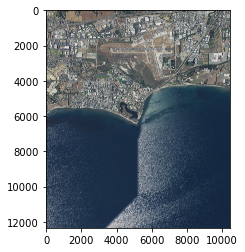

In [17]:
# check image
plt.imshow(np.moveaxis(ds.read(indexes=[1,2,3]),0,-1))

In [70]:
# Explore opened dataset
print('type: ', type(ds))
print('mode: ', ds.mode)
print('# bands: ', ds.count)
print('height: ',ds.height)
print('width: ', ds.width)

print('spatial bounding box: ')
print(ds.bounds)
print('affine transform: ')
print(ds.transform)   # see also get_transform() and read_transform()
print('CRS: ', ds.crs)
print('resolution:', ds.res)

type:  <class 'rasterio.io.DatasetReader'>
mode:  r
# bands:  4
height:  12340
width:  10420
spatial bounding box: 
BoundingBox(left=235476.0, bottom=3807168.0, right=241728.0, top=3814572.0)
affine transform: 
| 0.60, 0.00, 235476.00|
| 0.00,-0.60, 3814572.00|
| 0.00, 0.00, 1.00|
CRS:  EPSG:26911
resolution: (0.6, 0.6)


In [34]:
print(item.datetime)
type(item)

2018-07-22 00:00:00+00:00


pystac.item.Item

## Inspect GBIF 2018 ice plant data

In [36]:
# open as GeoDataFrame
fp = '/home/jovyan/ice_plant_training_set/observations-220884.csv'
obs = gpd.GeoDataFrame(
    pd.read_csv(fp), 
    crs = "EPSG:4326",
    geometry = gpd.points_from_xy(
        x=obs.longitude, 
        y=obs.latitude)
)

In [96]:
obs.columns

Index(['id', 'observed_on_string', 'observed_on', 'time_observed_at',
       'time_zone', 'user_id', 'user_login', 'created_at', 'updated_at',
       'quality_grade', 'license', 'url', 'image_url', 'sound_url', 'tag_list',
       'description', 'num_identification_agreements',
       'num_identification_disagreements', 'captive_cultivated',
       'oauth_application_id', 'place_guess', 'latitude', 'longitude',
       'positional_accuracy', 'private_place_guess', 'private_latitude',
       'private_longitude', 'public_positional_accuracy', 'geoprivacy',
       'taxon_geoprivacy', 'coordinates_obscured', 'positioning_method',
       'positioning_device', 'species_guess', 'scientific_name', 'common_name',
       'iconic_taxon_name', 'taxon_id', 'geometry'],
      dtype='object')


In [98]:
obs.positional_accuracy

0        NaN
1        8.0
2        5.0
3        5.0
4        5.0
5        NaN
6        5.0
7       10.0
8       10.0
9       10.0
10       5.0
11      10.0
12      10.0
13    4527.0
Name: positional_accuracy, dtype: float64

In [89]:
coords = obs[['geometry']]
coords = coords.to_crs(ds.crs)
coords['xy'] = coords.geometry.apply(lambda p: (p.x,p.y))
coords
#coords

,geometry,xy
0,POINT (267975.733 3808626.887),"(267975.73328417906, 3808626.886953532)"
1,POINT (238399.666 3810854.686),"(238399.66635965343, 3810854.6858756235)"
2,POINT (238161.595 3810936.091),"(238161.59452229345, 3810936.090928188)"
3,POINT (238396.613 3810861.015),"(238396.61338852625, 3810861.014677771)"
4,POINT (238156.566 3810942.123),"(238156.56556926286, 3810942.1228833455)"
5,POINT (238168.362 3810934.317),"(238168.36243180145, 3810934.317332327)"
6,POINT (238402.912 3810859.251),"(238402.91166871192, 3810859.2511430746)"
7,POINT (254847.579 3811631.283),"(254847.57949129806, 3811631.282619651)"
8,POINT (254545.729 3811605.170),"(254545.7286688104, 3811605.1695517134)"
9,POINT (256842.634 3811591.667),"(256842.6335378319, 3811591.667249088)"


<AxesSubplot:>

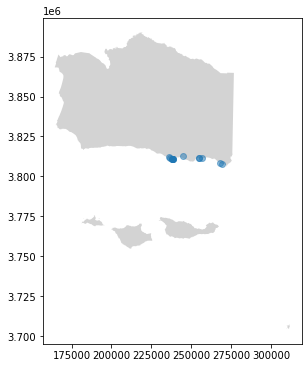

In [69]:
# ---- OPEN SB shapefile ----

sb_shape_path = "/home/jovyan/Sedgwick_Reserve/SB_geometry/SB_only.shp"
sb_shape = gpd.read_file(sb_shape_path)
sb_shape = sb_shape.to_crs(ds.crs)

fig, ax = plt.subplots(figsize = (6,6))
sb_shape.plot(ax=ax, color='lightgrey')
coords.plot(ax=ax, alpha=0.5)

## Sample NAIP image data at observation coords

In [111]:
sample = ds.sample(coords.xy)

In [91]:
for i in sample:
    print(i)

[0 0 0 0]
[40 50 65 59]
[ 82  86  89 141]
[172 166 154 168]
[127 121 119 135]
[102  97  96 137]
[178 176 164 162]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[0 0 0 0]
[156 159 138 185]
[ 83  79  81 127]
[0 0 0 0]


In [118]:
data = []
for i in sample:
    if (i!= [0,0,0,0]).all():
        data.append(i)
data

[array([ 82,  86,  89, 141], dtype=uint8),
 array([172, 166, 154, 168], dtype=uint8),
 array([127, 121, 119, 135], dtype=uint8),
 array([102,  97,  96, 137], dtype=uint8),
 array([178, 176, 164, 162], dtype=uint8),
 array([156, 159, 138, 185], dtype=uint8),
 array([ 83,  79,  81, 127], dtype=uint8)]

In [119]:
df = pd.DataFrame(data, columns=['r','g','b','nifr'])
df

,r,g,b,nifr
0,82,86,89,-115
1,-84,-90,-102,-88
2,127,121,119,-121
3,102,97,96,-119
4,-78,-80,-92,-94
5,-100,-97,-118,-71
6,83,79,81,127


## TO DO: mask coords within the NAIP image?

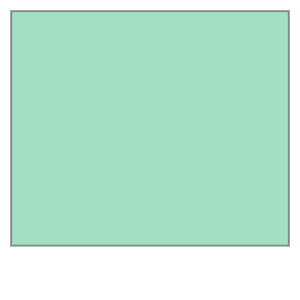

In [106]:
from shapely.geometry import shape

dsb = ds.bounds
bbox = { 
            'type': 'Polygon',
            'coordinates' : [[
                [dsb.top,dsb.left],
                [dsb.bottom,dsb.left],
                [dsb.bottom,dsb.right],
                [dsb.top,dsb.right],
                [dsb.top,dsb.left]
            ]]
           }
bbox_shape = shape(bbox)
bbox_shape

In [107]:
in_naip = gpd.clip(coords,bbox_shape)

In [109]:
type(bbox_shape)

shapely.geometry.polygon.Polygon